## lens modelling of SDSS J1627-0053
This notebooks takes the data and psf configurations of the pre-analysis and configures (and runs) the lens modelling and parameter inference.
There are two modes:
    - local execution of a single model: this is mostly to test a model and having an output in a finite time. Thius is the default setting of this notebook.
    - cluster compute: it sends the configuration files to a cluster where the same models can be executed on multiple cores. This is the mode the results were produced.
    
In the second mode, the notebook initializes all the models that have been included in the analysis of Birrer et al. 2018.
In the last blocks of the notebook, some quick model inspections are performed.

### import libraries

In [1]:
import lenstronomy

lenstronomy.__version__

'1.7.0'

In [2]:
import numpy as np
import os
import pickle
import copy
import time
import h5py
from pprint import pprint
import joblib
import lenstronomy.Util.util as util
from lenstronomy.Workflow.fitting_sequence import FittingSequence
from lenstronomy.Plots.model_plot import ModelPlot
from lenstronomy.Plots import chain_plot
from lenstronomy.Sampling.parameters import Param
#from lenstronomy.Analysis.lens_analysis import LensAnalysis
from lenstronomy.Util import mask_util
from lenstronomy.Data.coord_transforms import Coordinates
from lenstronomy.Util.util import array2image
cwd = os.getcwd()
base_path, _ = os.path.split(cwd)
print('Base directory path:', base_path)

Base directory path: /data/des80.a/data/chinyi/data/Feb_21/1627


### plot settings

In [3]:
import matplotlib as mpl

# for MNRAS
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid, make_axes_locatable
import matplotlib.image as mpimg
import seaborn as sns
import coloripy as cp

# to change tex to Times New Roman in mpl
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['mathtext.it'] = 'serif:italic'
plt.rcParams['mathtext.bf'] = 'serif:bold'
plt.rcParams['mathtext.fontset'] = 'custom'


sns.set(style='ticks', context='paper', font='Times New Roman', font_scale=2.)
#sns.set_context('talk')
sns.set_style({"xtick.direction": "in","ytick.direction": "in", "axes.linewidth": 2.0,})
#sns.set_palette('Set2')

cmap = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.6, dark=0.8, reverse=False, as_cmap=True)
cmap2 = sns.cubehelix_palette(start=0.5, rot=-1.5, gamma=1, hue=1, light=-.2, dark=1., reverse=False, as_cmap=True)
#divmap = sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=True)
#sns.palplot(sns.diverging_palette(348., 232, s=74.35, l=42.65, as_cmap=False))

#rgb1 = np.array([59, 76, 192])
#rgb2 = np.array([180, 4, 38])

msh_cmap = cp.get_msh_cmap(num_bins=501, rescale='power', power=2.5)

### set up the Data() and PSF() class of lenstronomy

In [4]:
import h5py

def import_data(filter_name):
    data_file = os.path.join(base_path, 'data', 'data_{}.hdf5'.format(filter_name))
    f = h5py.File(data_file, 'r')
    
    data_reduced = f['image_data'][()]
    background_rms = f['background_rms'][()]
    exposure_time = f['exposure_time'][()]
    ra_at_xy_0 = f['ra_at_xy_0'][()]
    dec_at_xy_0 = f['dec_at_xy_0'][()]
    transform_pix2angle = f['transform_pix2angle'][()]
    f.close()

    kwargs_data = {'image_data': data_reduced, 
                    'background_rms': background_rms,
                    'noise_map': None,
                    'exposure_time': exposure_time,
                    'ra_at_xy_0': ra_at_xy_0,
                    'dec_at_xy_0': dec_at_xy_0, 
                    'transform_pix2angle': transform_pix2angle
                    }

    # get data and PSF estimate from file
    psf_file = os.path.join(base_path, 'data', 'psf_{}.hdf5'.format(filter_name))
    f = h5py.File(psf_file, 'r')
    kernel_point_source = f['kernel_point_source'][()]
  #  psf_error_map = f['psf_error_map'][()]
    f.close()


    kwargs_psf = {'psf_type': "PIXEL", 
                   'kernel_point_source': kernel_point_source ,
                   'kernel_point_source_init': kernel_point_source ,
                 #  'psf_error_map': psf_error_map,
                   }
    
    return kwargs_data, kwargs_psf

kwargs_data_f814w, kwargs_psf_f814w = import_data('f390w')
#kwargs_data_f814w, kwargs_psf_f814w = import_data('f814w')
#kwargs_data_f475x, kwargs_psf_f475x = import_data('f475x')

#kwargs_data_f160w['ra_shift'], kwargs_data_f160w['dec_shift'] = 0.16715537453414964, -0.09043700974925503 #0.07512840424965349, 0.006380280266175261

## show image and initial guesses of point source coordinates

/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in log10
  app.launch_new_instance()
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


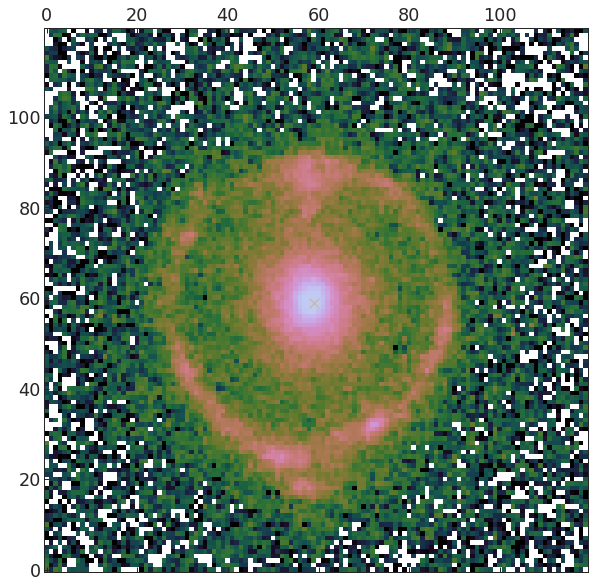

In [5]:
#%matplotlib notebook
%matplotlib inline 

# read-in the coordiante system of the exposure

ra_at_xy_0 = kwargs_data_f814w['ra_at_xy_0']
dec_at_xy_0 = kwargs_data_f814w['dec_at_xy_0']
transform_pix2angle = kwargs_data_f814w['transform_pix2angle']
coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)

# read-in the reduced cutout image
data_cutout = kwargs_data_f814w['image_data']
numPix = len(data_cutout)

ax = plt.figure(figsize=(10, 10)).add_subplot(111)
ax.matshow(np.log10(data_cutout), origin='lower', cmap=cmap, vmin=-5, vmax=-1.)
ax.autoscale(False)

# estimate point source positions in (ra/dec)
# im_pos_x_pix = [66.1, 13.1, 50.05, 57.2]
# im_pos_y_pix = [50.9, 35.8, 58.9, 36.9]
# im_pos_ra, im_pos_dec = coords.map_pix2coord(im_pos_x_pix, im_pos_y_pix)

lens_center_ra, lens_center_dec = coords.map_pix2coord(59, 59)

x_at_radec_0, y_at_radec_0 = coords.map_coord2pix(0, 0)
#x_image, y_image = coords.map_coord2pix(im_pos_ra, im_pos_dec)
#ax.plot(x_image, y_image, 'or')

# for i in range(len(x_image)):
#     ax.text(x_image[i], y_image[i], i, fontsize=20)

lens_x, lens_y = coords.map_coord2pix(lens_center_ra, lens_center_dec)
ax.plot(lens_x, lens_y, 'x', color='y', markersize=10)    
#plt.colorbar()
plt.show()

In [6]:
#print(coords.map_pix2coord(101.554, 99.8189))

0.040000194584270246


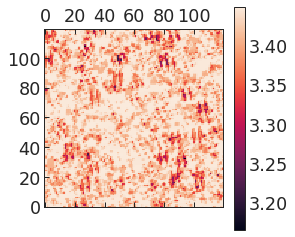

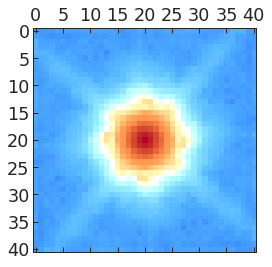

In [7]:
%matplotlib inline 

deltaPix = coords.pixel_width
print(deltaPix)
x_coords, y_coords = coords.coordinate_grid(numPix, numPix)
wht_map = kwargs_data_f814w['exposure_time']

plt.matshow(np.log10(wht_map), origin='lower') #, cmap=msh_cmap)
plt.autoscale(False)

#plt.plot(x_image,y_image,'or')

# for i in range(len(x_image)):
#     plt.text(x_image[i], y_image[i], i, fontsize=20)

plt.colorbar()
plt.show()


psf_kernel = kwargs_psf_f814w['kernel_point_source']
plt.matshow(np.log10(psf_kernel), vmin=-6, cmap=msh_cmap)
plt.show()

### set the masking regions used in the analysis

/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: divide by zero encountered in log10
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in log10
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in log10
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


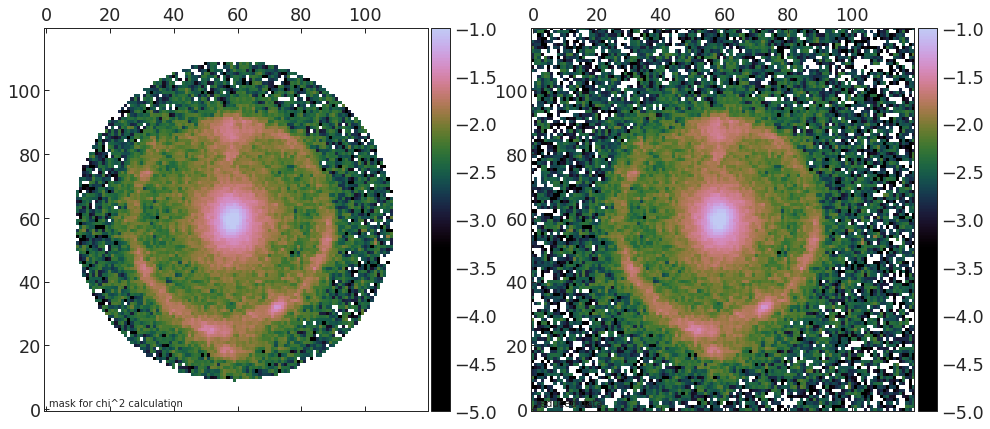

In [8]:
r_mask_list = [
    [2], # f814w 
    ]

mask_list = []
#index_mask_list = []

for i in range(len(r_mask_list[0])):
    mask_bands = []
    index_mask_bands = []

    for j, kwargs_data in enumerate([kwargs_data_f814w]):
        ra_at_xy_0 = kwargs_data['ra_at_xy_0']
        dec_at_xy_0 = kwargs_data['dec_at_xy_0']
        transform_pix2angle = kwargs_data['transform_pix2angle']
        coords = Coordinates(transform_pix2angle, ra_at_xy_0, dec_at_xy_0)
        num_pix = len(kwargs_data['image_data'])

        x_coords, y_coords = coords.coordinate_grid(num_pix, num_pix)
        
        r = r_mask_list[j][i]
        
        mask_outer = mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r, util.image2array(x_coords), util.image2array(y_coords))
#         index_mask = 1 - mask_util.mask_center_2d(lens_center_ra, lens_center_dec, r+0.3, util.image2array(x_coords), util.image2array(y_coords))

#         mask_ext1 = 1 - mask_util.mask_center_2d(lens_center_ra+1.3, lens_center_dec+0.9, .5, util.image2array(x_coords), util.image2array(y_coords))
#         mask_ext2 = 1 - mask_util.mask_center_2d(lens_center_ra-1.6, lens_center_dec+1.1, .45, util.image2array(x_coords), util.image2array(y_coords))
    
        mask = (1 - mask_outer) # * (1- mask_ext1) * (1 - mask_ext2)
        
        #mask = 1 - (1 - mask_ext8) * (1 - mask_ext9)
        
        mask[mask >= 1] = 1
        mask[mask < 0] = 0
        
        mask_bands.append(array2image(mask))
        #index_mask_bands.append(index_mask)
        
    mask_list.append(mask_bands)
    #index_mask_list.append(index_mask_bands)
    

for j, kwargs_data in enumerate([kwargs_data_f814w]):
    image = kwargs_data['image_data']
    
    f, axes = plt.subplots(1, len(r_mask_list[0])+1, figsize=(16, 8), sharex=False, sharey=False)
    for i in range(len(mask_list)):
        ax = axes[i]
        
        mask = mask_list[i][j]
        
        im = ax.matshow(np.log10(image*mask), origin='lower', cmap=cmap, vmax=-1, vmin=-5)
        ax.text(1, 1, 'mask for chi^2 calculation')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        ax = axes[i+1]
        im = ax.matshow(np.log10(image), origin='lower', cmap=cmap, vmax=-1, vmin=-5)
        ax.text(1, 1, 'reduced data')
        ax.autoscale(False)
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.05)
        plt.colorbar(im, cax=cax)

        plt.show()

## supersampling mask

In [9]:
threshold = 10**(5/2.5) # pixels with flux > max_flux/threshold will not be supersampled

supersampling_mask = []

# for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
#     s_mask = np.ones_like(kwargs_data['image_data'])
    
#     max_flux = np.max(kwargs_data['image_data'])
#     s_mask[kwargs_data['image_data'] < max_flux/threshold] = 0
    
#     supersampling_mask.append(s_mask)

# for j, kwargs_data in enumerate([kwargs_data_f814w, kwargs_data_f475x, kwargs_data_f160w]):
#     image = kwargs_data['image_data']
    
#     fig = plt.figure(figsize=(6,6))
#     ax = fig.add_subplot(111)

#     mask = supersampling_mask[j]*mask_list[0][j]
#     im = ax.matshow(np.log10(image*mask), origin='lower')
#     ax.text(1, 1, 'mask for chi^2 calculation')
#     ax.autoscale(False)
#     divider = make_axes_locatable(ax)
#     cax = divider.append_axes("right", size="5%", pad=0.05)
#     plt.colorbar(im, cax=cax)

#     plt.show()

### Options for lenstronomy

In [10]:
lens_center_ra, lens_center_dec

(0.04000067507879912, -0.03999972143723518)

In [11]:
ssh_command = 'ajshajib@hoffman2.idre.ucla.edu'
dir_path = os.getcwd()
dir_path_cluster = '~/Desktop/Strong_Lensing/mcmc'

# numeric settings
band_number = 1

n_p_short = 40  # number of particles in the PSO (for tests)
n_i_short = 100 # number of iterations of the PSO (for tests)
n_p_long = 192 # number of particles in the PSO 
n_i_long = 200  # number of iterations of the PSO 

do_mcmc = True
mcmc_n_burn = 0
mcmc_n_run = 2000
walker_ratio = 4

psf_iteration = False  # bool, we perform an iterative PSF reconstruction
psf_iter_num = 50  # number of steps in the PSF reconstruction
psf_iter_factor = 0.5  # factor of f* new + (1-f)* old PSF in each iterative step
psf_symmetry = 4  # number of symmetry axis rotations

# lens model settings
lens_bound = 0.32 # bound for lens position from the initial position
group_halo = False # additon an additonal group halo in addition to the main deflector
mass_scaling = False # keep mass scaling fixed for external perturbers
mass_light_scatter_dex = 0.1 # scatter in the M/L ratio of the external perturbers
composite_type = 'CHAMELEON' # 'CHAMELEON', 'MGE', 'INTERPOL', 'DOUBLE_CHAMELEON'
mass_light_joint = True # joint mass and light parameters in the composite model option

shear = True # adding of a external shear component in the model
solver_type = ''
flexion = False # addition of explicit flextion terms in the model

with_perturber = False
params_perturber = [{'e1': 0.03441141057470183, 'e2': 0.1083376284000062,
                     'center_x': -2.512650057751154, 'center_y': 14.927020350801785}]

theta_E_perturber_list = [5.]

# lens light settings
power_law_lens_light_list = [['SERSIC_ELLIPSE'],
                             #['SERSIC_ELLIPSE', 'UNIFORM'],
                             #['SERSIC_ELLIPSE', 'UNIFORM'],
                            ]
# composite_lens_light_list = [['CHAMELEON', 'UNIFORM'],
#                              ['SERSIC_ELLIPSE', 'UNIFORM'],
#                              ['SERSIC_ELLIPSE', 'UNIFORM'],
#                             ]

# source settings
source_light_model_list_template = [] # don't need to add shapelets as it's added inside the function
with_shapelets = True
shapelet_beta = 0.15 # initial guess of the shapelet scale (in arcsec)

# point source settings
point_source_model_list = ['SOURCE_POSITION']  # we model the point sources in the image plane

def configure_model(job_name, deflector_model, perturber_model, num_perturber, mask, n_max_list, subgrid_res, foreground_shear=False, group_halo=False, cluster_compute=True, verbose=False):
    """
    this definitons takes as an input some specific options that are varried in the modelling and merges them
    with the other choices made and runs the modeling and parameter inference
    
    job_name: string, the file with its specific configuration will be named that way
    lens_model: string: 'composite', 'SPEMD' as options
    perturber_model: string, type of model for the perturbers ('SIS', 'SIE', 'NFW', ...)
    mask: 2d numpy array, masking region of fit
    n_max: maximal polynomial order of shapelets in the source plane
    foreground_shear: bool, if True, adds a foreground shear model
    subgrid_res: subsampling of the surface brightness of pixels
    num_perturber: integer, number of perturbers being modeled (in subsequent order of the defined list above)
    group_halo: bool, additon an additonal group halo in addition to the main deflector
    cluser_compute: bool, if True, instead of running the chain, saves and copies the configuration files to a cluster
    """
    #global with_shapelets #, lens_result, ps_result, source_result, lens_light_result, psf_iter_num, psf_iter_factor
    
    #n_max_start = n_max #-1  # we start with a simple model (without shapelets) and then later no in the fit add complexity if required

    #if n_max_start == -1:
    #    with_shapelets = False
    
    #with_shapelets = True
    #triple_type = perturber_model
    #lens_model = 'SPEMD'  # 'NFW_SERSIC', 'NFW_PJAFFE', 'SPEMD', 'COMPOSITE', 'NFW_SERSIC_DOUBLE'
    
    if with_shapelets:
        source_light_model_list_template.append('SHAPELETS')
    
    if deflector_model == 'composite':
        lens_light_model_list_template = composite_lens_light_list
    else:
        lens_light_model_list_template = power_law_lens_light_list
    
    #  ======================================================  #
    #  SPECIFY PARAMETER CONSTRAINTS  #
    #  ======================================================  #

    #  ======================================================  #
    # lens models
    #  ======================================================  #

    lens_model_list = []
    fixed_lens = []
    kwargs_lens_init = []
    kwargs_lens_sigma = []
    kwargs_lower_lens = []
    kwargs_upper_lens = []
    mass_scaling_list = []
    joint_lens_with_light = []
    joint_lens_with_lens = []
    
    if deflector_model == 'PEMD':
        mass_scaling_list.append(False)
        lens_model_list.append('PEMD')
        fixed_lens.append({'gamma': 2.})
        kwargs_lens_init.append({'center_x': lens_center_ra,
                                 'center_y': lens_center_dec,
                                 'e1': 0.,
                                 'e2': 0,
                                 'gamma': 2.0,
                                 'theta_E': 1.}
                               )
        kwargs_lens_sigma.append({'theta_E': .1, 'e1':0.1, 'e2':0.1, 'gamma': 0.02
                    , 'center_x': 0.1, 'center_y': 0.1})
        kwargs_lower_lens.append({'theta_E': 0.01, 'e1': -0.5, 'e2': -0.5, 'gamma': 1.2, 
                             'center_x': lens_center_ra-lens_bound, 'center_y': lens_center_dec-lens_bound})
        kwargs_upper_lens.append({'theta_E': 2., 'e1': 0.5, 'e2': 0.5, 'gamma': 2.8, 
                             'center_x': lens_center_ra+lens_bound, 'center_y': lens_center_dec+lens_bound})
    elif deflector_model == 'composite':
        # Sersic fit to the lens light profile
        lens_model_list.append('NFW_ELLIPSE')
        
        mass_scaling_list.append(False)
        
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_Rs': .8, 'Rs': 5., 'center_x': -0.0015653120745398427, 'center_y': 0.05678130863602721, 'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'theta_Rs': 0.5, 'Rs': 2., 'center_x': 0.1, 'center_y': 0.1, 'e1':0.2, 'e2':0.2})
        kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': 2., 'center_x': lens_center_ra-0.2, 'center_y': lens_center_dec-0.2, 'e1': -0.5, 'e2': -0.5})
        kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 30, 'center_x': lens_center_ra+0.2, 'center_y': lens_center_dec+0.2, 'e1': 0.5, 'e2': 0.5})
        
        lens_light_kwargs = [{'R_sersic': 1.891669842263023,
                              'amp': 200.1774179659085,
                              'center_x': 0.015002635516859297,
                              'center_y': 0.005094163369226864,
                              'e1': -0.057491322321114,
                              'e2': 0.2334461197639937,
                              'n_sersic': 2.9825115316824213},
                             {'R_sersic': 4.453962446845857,
                              'amp': 3.839331247477446,
                              'center_x': 0.015002635516859297,
                              'center_y': 0.005094163369226864,
                              'e1': 0.30370833824488086,
                              'e2': -0.3152280141881175,
                              'n_sersic': 0.8488108992428869},
                             {'R_sersic': 4.990895453811525,
                              'amp': 3.840330206304584,
                              'center_x': 0.015002635516859297,
                              'center_y': 0.005094163369226864,
                              'e1': -0.4970231025961503,
                              'e2': -0.38025531033886817,
                              'n_sersic': 0.6705922722619663},
                             ]
        
        #light_model_list=['SERSIC_ELLIPSE', 'SERSIC_ELLIPSE']

        if composite_type == 'TRIPLE_CHAMELEON':
            i_light = 8
            k_lens = 1
            
            if mass_light_joint is True:
                joint_with_light_list.append([i_ligth, k_lens, ['ratio12', 'ratio13', 'w_c1', 'w_t1', 'e11', 'e21', 
                                                                'w_c2', 'w_t2', 'e12', 'e22', 'w_c3', 'w_t3', 'e13', 'e23', 
                                                                'center_x', 'center_y']])
            
            kwargs_chameleon = {'theta_E': .8, 'ratio12': 1, 'ratio13': 1., 
                                'w_c1': 0.15, 'w_t1': 0.003, 'e11': 0.098, 'e21': -0.19, 
                                'w_c2': 0.26, 'w_t2': 0.66, 'e12': 0.095, 'e22': 0.01, 
                                'w_c3': 0.26, 'w_t3': 0.66, 'e13': 0.095, 'e23': 0.01, 
                                'center_x': 0, 'center_y': 0.06}
            lens_model_list.append('TRIPLE_CHAMELEON')
            lens_model_deflector_bool.append(True)
            mass_scaling_list.append(False)
            fixed_lens.append({})
            kwargs_lens_init.append(kwargs_chameleon)
            kwargs_lens_sigma.append({'theta_E': 0.6})
            kwargs_lower_lens.append({'theta_E': 0})
            kwargs_upper_lens.append({'theta_E': 10})
        else:
            raise NotImplementedError

    if group_halo is True:
        lens_model_list.append('NFW')
        mass_scaling_list.append(False)
        fixed_lens.append({})
        kwargs_lens_init.append({'theta_Rs': 0.1, 'Rs': 10., 'center_x': lens_center_ra, 'center_y': lens_center_dec})
        kwargs_lens_sigma.append({'theta_Rs': 0.1, 'Rs': 1., 'center_x': 1, 'center_y': 1})
        kwargs_lower_lens.append({'theta_Rs': 0, 'Rs': .01, 'center_x': -10, 'center_y': -10})
        kwargs_upper_lens.append({'theta_Rs': 10, 'Rs': 30, 'center_x': 10, 'center_y': 10})

    if shear:
        """lens_model_list.append('SHEAR')
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'e1': 0.038, 'e2': -0.081})
        kwargs_lens_sigma.append({'e1':0.1, 'e2':0.1})
        kwargs_lower_lens.append({'e1': -0.2, 'e2': -0.2})
        kwargs_upper_lens.append({'e1': 0.2, 'e2': 0.2})"""
        lens_model_list.append('SHEAR_GAMMA_PSI')
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'gamma_ext': 0.05, 'psi_ext': 0.0})
        kwargs_lens_sigma.append({'gamma_ext': 0.01, 'psi_ext': np.pi/90})
        kwargs_lower_lens.append({'gamma_ext': 0.0, 'psi_ext': -np.pi})
        kwargs_upper_lens.append({'gamma_ext': 0.5, 'psi_ext': np.pi})

    if foreground_shear:
        lens_model_list.append('FOREGROUND_SHEAR')
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'e1': 0, 'e2': 0})
        kwargs_lens_sigma.append({'e1':0.005, 'e2':0.005})
        kwargs_lower_lens.append({'e1': -0.01, 'e2': -0.01})
        kwargs_upper_lens.append({'e1': 0.01, 'e2': 0.01})

    if flexion:
        lens_model_list.append('FLEXION')
        mass_scaling_list.append(False)
        fixed_lens.append({'ra_0': 0, 'dec_0': 0})
        kwargs_lens_init.append({'g1': 0, 'g2': 0, 'g3': 0, 'g4': 0})
        kwargs_lens_sigma.append({'g1': 0.01, 'g2': 0.01, 'g3': 0.01, 'g4': 0.01})
        kwargs_lower_lens.append({'g1': -0.1, 'g2': -0.1, 'g3': -0.1, 'g4': -0.1})
        kwargs_upper_lens.append({'g1': 0.1, 'g2': 0.1, 'g3': 0.1, 'g4': 0.1})
    
    for i in range(num_perturber):
        lens_model_list.append(perturber_model)
        
        #mass_scaling_list.append(perturber_mass_scaling[i])
        
        #if set_true_perturber_redshift[i]:
        #    lens_redshift_list.append(perturber_redshift[i])
        #else:
        #    lens_redshift_list.append(deflector_redshift)
            
        #if set_perturber_multi_lens_plane[i]:
        #    observed_convention_index_list.append(len(lens_model_list)-1)

        #if perturber_mass_profile_sis_fix[i]:
        #    perturber_mass_model = 'SIS'
        #else:
        
        perturber_mass_model = perturber_model
        
        if perturber_mass_model == 'NFW':
            if mass_scaling is True:
                fixed_lens.append({'theta_Rs': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 'center_y': params_perturber[i]['center_y']})
            kwargs_lens_init.append({'alpha_Rs': theta_E_perturber_list[i], 'Rs': 5., 'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y']})
            kwargs_lens_sigma.append({'alpha_Rs': theta_E_perturber_list[i]/3., 'Rs': 1.})
            kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': .01, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'alpha_Rs': 10, 'Rs': 20, 'center_x': 100, 'center_y': 100})
        elif perturber_mass_model == 'NFW_ELLIPSE':
            if mass_scaling is True:
                fixed_lens.append({'alpha_Rs': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_init.append({'alpha_Rs': theta_E_perturber_list[i], 'Rs': 5., 'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                     'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'alpha_Rs': theta_E_perturber_list[i]/3., 'Rs': 1., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'alpha_Rs': 0, 'Rs': .01, 'e1': -0.3, 'e2': -0.3, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'alpha_Rs': 20, 'Rs': 10, 'e1': 0.3, 'e2': 0.4, 'center_x': 100, 'center_y': 100})
        elif perturber_mass_model == 'SIS':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y']})
            kwargs_lens_init.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                     'center_y': params_perturber[i]['center_y']})
            kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3.})
            kwargs_lower_lens.append({'theta_E': 0, 'center_x': -100, 'center_y': -100})
            kwargs_upper_lens.append({'theta_E': 20, 'center_x': 100, 'center_y': 100})
        elif perturber_mass_model == 'SIE':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 
                                   #'e1': params_perturber[i]['e1'], 
                                   #'e2': params_perturber[i]['e2']
                                  })
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 
                                   #'e1': params_perturber[i]['e1'], 
                                   #'e2': params_perturber[i]['e2']
                                  })
            kwargs_lens_init.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3., 'e1': 0.1, 'e2': 0.1})
            kwargs_lower_lens.append({'theta_E': 0.1, 'center_x': -100, 'center_y': -100, 'e1': -0.3, 'e2': 0.3})
            kwargs_upper_lens.append({'theta_E': 20, 'center_x': 100, 'center_y': 100, 'e1': 0.3, 'e2': 0.4})

        elif perturber_mass_model == 'PEMD':
            if mass_scaling is True:
                fixed_lens.append({'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            else:
                fixed_lens.append({'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_init.append({'gamma': 2., 'theta_E': theta_E_perturber_list[i], 'center_x': params_perturber[i]['center_x'], 
                                   'center_y': params_perturber[i]['center_y'], 'e1': params_perturber[i]['e1'], 
                                   'e2': params_perturber[i]['e2']})
            kwargs_lens_sigma.append({'theta_E': theta_E_perturber_list[i]/3, 'e1': 0.1, 'e2': 0.1, 'gamma': 0.1,
                                      'center_x': 0.1, 'center_y': 0.1})
            kwargs_lower_lens.append({'theta_E': 0.1, 'gamma': 1.5, 'center_x': -100, 'center_y': -100, 'e1': -0.3, 'e2': -0.3})
            kwargs_upper_lens.append({'theta_E': 20, 'gamma': 2.5, 'center_x': 100, 'center_y': 100, 'e1': 0.3, 'e2': 0.4})
        else:
            raise ValueError("not a valid perturber model option!", perturber_mass_model)
            
    lens_params = [kwargs_lens_init, kwargs_lens_sigma, fixed_lens, kwargs_lower_lens, kwargs_upper_lens]


    #  ======================================================  #
    # lens light models
    #  ======================================================  #
    
    lens_light_model_list = []
    fixed_lens_light = []
    kwargs_lens_light_init = []
    kwargs_lens_light_sigma = []
    kwargs_lower_lens_light = []
    kwargs_upper_lens_light = []
    joint_lens_light_with_lens_light = []
    lens_light_model_list = []
    lens_light_indices = [[], [], []]
    
    lens_light_index_with_centroid = 0
    
    for band_num in range(band_number):
        for i, model in enumerate(lens_light_model_list_template[band_num]):
            if (i == 0 and band_num == 0) or model == 'UNIFORM':
                pass
            else:
                joint_lens_light_with_lens_light.append([lens_light_index_with_centroid, len(lens_light_model_list), 
                                                         ['center_x', 'center_y', 'e1', 'e2', 'R_sersic', 'n_sersic']])
                pass
                
            # joining ellipticities only in UVIS filters
            #if band_num == 1 and ('ELLIPSE' in model or 'CHAMELEON' in model):
            #    joint_lens_light_with_lens_light.append([i, len(lens_light_model_list), ['e1', 'e2']])
            #    joint_lens_light_with_lens_light.append([i, len(lens_light_model_list), ['center_x', 'center_y']])

            if model == 'SERSIC':
                lens_light_model_list.append('SERSIC')
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'R_sersic': 0.2, 'n_sersic': 4, 
                                           'center_y': lens_center_dec, 'center_x': lens_center_ra})
                kwargs_lens_light_sigma.append({'center_x': deltaPix, 'center_y': deltaPix, 'R_sersic': 0.05,
                                           'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'R_sersic': 0.01, 'n_sersic': 0.5, 
                                                'center_y': lens_center_dec-lens_bound, 
                                                'center_x': lens_center_ra-lens_bound})
                kwargs_upper_lens_light.append({'R_sersic': 5., 'n_sersic': 8, 
                                                'center_y': lens_center_dec+lens_bound, 
                                                'center_x': lens_center_ra+lens_bound})
            elif model == 'SERSIC_ELLIPSE':
                lens_light_model_list.append('SERSIC_ELLIPSE')
                fixed_lens_light.append({})
                if i == 0:
                    kwargs_lens_light_init.append({'amp': 1.,
                                                   'R_sersic': .2,
                                                   'center_x': lens_center_ra,
                                                   'center_y': lens_center_dec,
                                                   'e1': 0,
                                                   'e2': 0,
                                                   'n_sersic': 4.0}
                                                 )
                else:
                    kwargs_lens_light_init.append({'amp': 0.0478,
                                                   'R_sersic': 4.99,
                                                   'center_x': -0.047,
                                                   'center_y': -0.004,
                                                   'e1': 0.199,
                                                   'e2': -0.303,
                                                   'n_sersic': 1.0}
                                                 )
                kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 
                                                'R_sersic': 0.05,
                                                'n_sersic': 0.5, 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'e1': -0.5, 'e2': -0.5, 'n_sersic': .5, 
                                                'R_sersic': 0.1, 'center_y': lens_center_dec-lens_bound, 
                                                'center_x': lens_center_ra-lens_bound})
                kwargs_upper_lens_light.append({'e1': 0.5, 'e2': 0.5, 
                                                'n_sersic': 8., 'R_sersic': 10., 
                                                'center_y': lens_center_dec+lens_bound, 
                                                'center_x': lens_center_ra+lens_bound})
            elif model == 'CHAMELEON':
                lens_light_model_list.append('CHAMELEON')
                fixed_lens_light.append({})
                if i == 0:
                    kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 0.8, 'w_c': .3, 
                                               'center_y': lens_center_dec, 'center_x': lens_center_ra})
                else:
                    kwargs_lens_light_init.append({'e1': 0, 'e2': 0, 'w_t': 1., 'w_c': .3, 
                                               'center_y': lens_center_dec, 'center_x': lens_center_ra})
                kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'w_t': 0.5, 'w_c': .1
                                           , 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'e1': -0.8, 'e2': -0.8, 'w_t': 0.001, 'w_c': .001, 'center_y': -10, 'center_x': -10})
                kwargs_upper_lens_light.append({'e1': 0.8, 'e2': 0.8, 'w_t': 10, 'w_c': 10, 'center_y': 10, 'center_x': 10})
            elif model == 'DOUBLE_CHAMELEON':
                lens_light_model_list.append('DOUBLE_CHAMELEON')
                fixed_lens_light.append({})
                kwargs_chameleon_init = {'ratio': 1.5, 'w_c1': 0.15, 'w_t1': 0.003, 'e11': 0.098, 'e21': -0.19, 'w_c2': 0.26, 'w_t2': 0.66, 'e12': 0.095, 'e22': 0.01, 'center_x': 0, 'center_y': 0.06}
                kwargs_lens_light_init.append(kwargs_chameleon_init)
                #{'ratio': 1, 'e11': 0, 'e21': 0, 'w_t1': 0.8, 'w_c1': .3, 'e12': 0, 'e22': 0, 'w_t2': 1., 'w_c2': .3,
                #                               'center_y': lens_center_dec, 'center_x': lens_center_ra}
                kwargs_lens_light_sigma.append({'ratio': 0.5, 'e11': 0.2, 'e21': 0.2, 'w_t1': 0.2, 'w_c1': .1, 'e12': 0.2, 'e22': 0.2, 'w_t2': .5, 'w_c2': .1,
                                               'center_y': deltaPix/10, 'center_x': deltaPix/10})
                kwargs_lower_lens_light.append({'ratio': 0, 'e11': -0.8, 'e21': -0.7, 'w_t1': 0.001, 'w_c1': .001, 'e12': -0.8, 'e22': -0.8, 'w_t2': .001, 'w_c2': .001,
                                               'center_y': -10, 'center_x': -10})
                kwargs_upper_lens_light.append({'ratio': 100, 'e11': 0.8, 'e21': 0.7, 'w_t1': 10, 'w_c1': 10, 'e12': 0.8, 'e22': 0.8, 'w_t2': 10, 'w_c2': 10,
                                               'center_y': 10, 'center_x': 10})
            elif model == 'PJAFFE_ELLIPSE':
                lens_light_model_list.append('PJAFFE_ELLIPSE')
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'Ra': .1, 'Rs': 0.5, 'center_x': lens_center_ra, 'center_y': lens_center_dec, 'e1': 0, 'e2': 0})
                kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'Rs': 0.1, 'e1': 0.1, 'e2': 0.1, 'Ra': 0.05})
                kwargs_lower_lens_light.append({'Ra': .01, 'Rs': 0.01, 'center_x': -10, 'center_y': -10, 'e1': -0.6, 'e2': -0.6})
                kwargs_upper_lens_light.append({'Ra': 10, 'Rs': 10, 'center_x': 10, 'center_y': 10, 'e1': 0.6, 'e2': 0.6})
            elif model == 'HERNQUIST_ELLIPSE':
                lens_model_list.append('HERNQUIST_ELLIPSE')
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'Rs': 0.5, 'center_x': lens_center_ra, 'center_y': lens_center_dec, 'e1': 0, 'e2': 0})
                kwargs_lens_light_sigma.append({'center_x': deltaPix/10, 'center_y': deltaPix/10, 'Rs': 0.1, 'e1': 0.1, 'e2': 0.1})
                kwargs_lower_lens_light.append({'Rs': 0.01, 'center_x': -10, 'center_y': -10, 'e1': -0.6, 'e2': -0.6})
                kwargs_upper_lens_light.append({'Rs': 10, 'center_x': 10, 'center_y': 10, 'e1': 0.6, 'e2': 0.6})
            elif model == 'UNIFORM':
                lens_light_model_list.append('UNIFORM')
                fixed_lens_light.append({})
                kwargs_lens_light_init.append({'amp': 0})
                kwargs_lens_light_sigma.append({'amp': 0.05})
                kwargs_lower_lens_light.append({'amp': -1})
                kwargs_upper_lens_light.append({'amp': 1})
                
            lens_light_indices[band_num].append(len(lens_light_model_list)-1)

    lens_light_params = [kwargs_lens_light_init, kwargs_lens_light_sigma, fixed_lens_light, kwargs_lower_lens_light, kwargs_upper_lens_light]
    
    #  ======================================================  #
    # source light models
    #  ======================================================  #
    
    # possibilities for source models: 'SERSIC_ELLIPSE', 'DOUBLE_SERSIC', 'DOUBLE_CORE_SERSIC', 'CORE_SERSIC', 'SHAPELETS', 'BULDGE_DISK'
    source_light_model_list = []
    fixed_source = []
    kwargs_source_init = []
    kwargs_source_sigma = []
    kwargs_lower_source = []
    kwargs_upper_source = []
    joint_source_with_point_source = []
    joint_source_with_source = []
    image_plane_source_list = []
    
    source_light_model_list = []
    source_light_indices = [[], [], []]
    
    i_ps = 0
    
    for band_num in range(band_number):
        for i, model in enumerate(source_light_model_list_template):
            joint_source_with_point_source.append([i_ps, len(source_light_model_list), ['center_x', 'center_y']])
            
            if model == 'SHAPELETS':    
                source_light_model_list.append('SHAPELETS')
                fixed_source.append({'n_max': n_max_list[band_num]})
                kwargs_source_init.append({'center_x': 0., 'center_y': 0., 'beta': shapelet_beta, 'n_max': n_max_list[band_num]})
                kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'beta': shapelet_beta/10., 'n_max': 2})
                kwargs_lower_source.append({'center_x': -10, 'center_y': -10, 'beta': 0.01, 'n_max': -1})
                kwargs_upper_source.append({'center_x': 10, 'center_y': 10, 'beta': 2., 'n_max': 55}) 
                # beta_max was previously 10, limiting to .15 so that other source components can fit first
            elif model == 'SERSIC':
                source_light_model_list.append('SERSIC')
                fixed_source.append({})
                kwargs_source_init.append({'amp': 8.551566241407272,
                                           'R_sersic': 0.2,
                                           'center_x': 0,
                                           'center_y': 0,
                                           'n_sersic': 1.}
                                         )
                kwargs_source_sigma.append({'center_x': 0.01, 
                                            'center_y': 0.01, 
                                            'R_sersic': 0.01,
                                            'n_sersic': 0.5})
                kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .5,
                                            'center_y': -10, 'center_x': -10})
                kwargs_upper_source.append({'R_sersic': .5, 'n_sersic': 8., 
                                            'center_y': 10, 'center_x': 10})

                #kwargs_source_init.append({'R_sersic': 1.04, 'n_sersic': 5.15, 'center_y': -0.36, 'center_x': 0.12})
                #kwargs_source_sigma.append({'center_x': 0.01, 'center_y': 0.01, 'R_sersic': 0.01,
                #                   'n_sersic': 0.5})
                #kwargs_lower_source.append({'R_sersic': 0.005, 'n_sersic': 0.5, 'center_y': -10, 'center_x': -10})
                #kwargs_upper_source.append({'R_sersic': 5, 'n_sersic': 8., 'center_y': 10, 'center_x': 10})
            elif model == 'SERSIC_ELLIPSE':
                if band_num != 0:
                    joint_source_with_source.append([i, len(source_light_model_list), ['e1', 'e2']])
                
                source_light_model_list.append('SERSIC_ELLIPSE')
                fixed_source.append({})
                
                if i == 0:
                    kwargs_source_init.append({'amp': 1., 'R_sersic': 0.2, 'center_x': 0, 'center_y': 0, 'n_sersic': 1., 'e1': 0., 'e2': 0.})
                else:
                    kwargs_source_init.append({'amp': 1., 'e1': 0., 'e2': 0., 'R_sersic': 0.2, 'n_sersic': 1., 'center_x': 0., 'center_y': 0.})
                
                kwargs_source_sigma.append({'center_x': 0.01, 
                                            'center_y': 0.01, 
                                            'R_sersic': 0.01,
                                            'n_sersic': 0.5, 'e1': 0.05, 'e2': 0.05})
                kwargs_lower_source.append({'R_sersic': 0.04, 'n_sersic': .5,
                                            'center_y': -10, 'center_x': -10, 'e1': -0.5, 'e2': -0.5})
                kwargs_upper_source.append({'R_sersic': .5, 'n_sersic': 8., 
                                            'center_y': 10, 'center_x': 10, 'e1': 0.5, 'e2': 0.5})
                
            source_light_indices[band_num].append(len(kwargs_source_init) - 1)
            
    source_params = [kwargs_source_init, kwargs_source_sigma, fixed_source, kwargs_lower_source, kwargs_upper_source]
    
    #  ======================================================  #
    # point source model
    #  ======================================================  #
    
    fixed_ps = [{}]
    kwargs_ps_init = [{}] #'ra_image': im_pos_ra, 'dec_image': im_pos_dec}]
    kwargs_ps_sigma = [{}] #'ra_image': deltaPix * np.ones(len(im_pos_ra)), 'dec_image': deltaPix * np.ones(len(im_pos_ra))}]
    kwargs_lower_ps = [{}] #'ra_image': im_pos_ra-0.32, 'dec_image': im_pos_dec-0.32}]
    kwargs_upper_ps = [{}] #'ra_image': im_pos_ra+0.32, 'dec_image': im_pos_dec+0.32}]

    ps_params = [kwargs_ps_init, kwargs_ps_sigma, fixed_ps, kwargs_lower_ps, kwargs_upper_ps]
    mass_scale_params = [{}, {}, {}, {}, {}] #'scale_factor': [1., 2.]}, {'scale_factor': [.5, 0.5]}, {}, {'scale_factor': [0, 0]}, {'scale_factor': [100, 100]}]

    kwargs_params = {'lens_model': lens_params,
                    'source_model': source_params,
                    'lens_light_model': lens_light_params,
                    'point_source_model': ps_params,
                    #'cosmography': mass_scale_params
                    }



    #  ======================================================  #
    #  SPECIFY MODEL OPTIONS  #
    #  ======================================================  #

    kwargs_model = {'lens_model_list': lens_model_list,
                    'source_light_model_list': source_light_model_list,
                    'lens_light_model_list': lens_light_model_list,
                    #'point_source_model_list': point_source_model_list,
                    'additional_images_list': [False],
                    'fixed_magnification_list': None,
                    'index_lens_light_model_list': lens_light_indices,
                    'index_source_light_model_list': source_light_indices,
                    #multi-plane options (optional):
                    'multi_plane': False,
                    'z_source': -1,
                    #'source_deflection_scaling_list': [1]*len(source_light_model_list)
                    #kinematics options (optinal):
                    #'lens_model_deflector_bool': lens_model_deflector_bool,
                    #'light_model_deflector_bool': light_model_deflector_bool # list of bools whether the light model is part of the main lens and its kinematics or not
                    }

    num_source_model = len(source_light_model_list)
    
    if len(source_light_model_list) > 1:
        joint_source_with_source = [[0, 1, ['center_x', 'center_y']]]
    else:
        joint_source_with_source = []
    joint_source_with_point_source = []
                                
    kwargs_constraints = {
                    'joint_lens_with_lens': joint_lens_with_lens,
                    'joint_lens_with_light': joint_lens_with_light, # list [[i_light, k_lens, ['param_name1', 'param_name2', ...]], [...], ...],
                    'joint_lens_light_with_lens_light': joint_lens_light_with_lens_light,
                    'joint_source_with_source': joint_source_with_source,
                    'joint_source_with_point_source': joint_source_with_point_source, # list [[i_point_source, k_source, ['param_name1', 'param_name2', ...]], [...], ...],
    
                    #'image_plane_source_list': [False]*num_source_model,
                    #'solver': True,
                    #'solver_type': 'ELLIPSE',  # 'PROFILE', 'PROFILE_SHEAR', 'ELLIPSE', 'CENTER'
                    #'mass_scaling': mass_scaling,
                    #'mass_scaling_list': mass_scaling_list,

                    'num_point_source_list': 0, #[len(im_pos_ra)],
                    #'fix_to_point_source_list': [True, True, False, False, False] if with_additional_sources else [True, True],
                    #'image_plane_source_list': [False, False]+[True]*len(additional_source_model) if with_additional_sources else [False, False],
                    #'joint_with_other_source_list': [False, False, False, 2, False] if with_additional_sources else [False, False],
                    #'solver_type': solver_type
                   }
    kwargs_likelihood = {'force_no_add_image': False,
                        'source_marg': False,
                        #'point_source_likelihood': True, 
                        'image_position_uncertainty': 0.00004,
                        'check_matched_source_position': False,
                        'source_position_tolerance': 0.001,
                        'check_positive_flux': False,
                        'check_bounds': True,
                        'bands_compute': [True, True, True],
                        'image_likelihood_mask_list': mask
                        }
    
    
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,
                       'psf_symmetry': 4,
                       'block_center_neighbour': 1.22/2,
                       'num_iter': psf_iter_num,
                       'psf_iter_factor': psf_iter_factor}

    multi_band_list = []
    
    #for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w], kwargs_data_f475x, kwargs_data_f160w], [kwargs_psf_f814w, kwargs_psf_f475x, kwargs_psf_f160w])):
    for i, (kwargs_data, kwargs_psf) in enumerate(zip([kwargs_data_f814w], [kwargs_psf_f814w])):
        # nummerical options (per band)
        kwargs_numerics_band = {'supersampling_factor': subgrid_res,
                                'supersampling_convolution': False, 
                                'supersampling_kernel_size': 3,
                                'flux_evaluate_indexes': None,
                                'point_source_supersampling_factor': 1,
                                'compute_mode': 'adaptive',  # 'adaptive'
                                #'supersampled_indexes': np.array(supersampling_mask[i]*mask[i], dtype=bool),
                               }

        band_list = [kwargs_data, kwargs_psf, kwargs_numerics_band]
        
        multi_band_list.append(band_list)
        
    kwargs_data_joint = {'multi_band_list': multi_band_list, 'multi_band_type': 'multi-linear'}
    
    kwargs_psf_iter = {'stacking_method': 'median',
                       'keep_psf_error_map': True,
                       'psf_symmetry': 4,
                       'block_center_neighbour': 1.13/2,
                       'num_iter': psf_iter_num,
                       'psf_iter_factor': psf_iter_factor,
                       'compute_bands': [True, True, True]
                      }
    
    #  ======================================================  #
    #  SPECIFY A FITTING SEQUENCE  #
    #  ======================================================  #

    if cluster_compute is True:
        n_i, n_p = n_i_long, n_p_long
        mpi = True
    else:
        n_i, n_p = n_i_short, n_p_short
        mpi = False
    
    shapelet_beta_fixed = False
    if n_max[0] < 0:
        shapelet_beta_fixed = True
    
    # here we run a series of fitting sequences one after the other
    def merge_dicts(x, y):
        z = x.copy()
        z.update(y)
        return z
    
    if verbose:
        print('lens model list:', lens_model_list)
        print('joint lens with lens:', joint_lens_with_lens)
        print('')
        print('lens light model list:', lens_light_model_list)
        print('lens light indices:', lens_light_indices)
        print('joint lens light with lens:', joint_lens_with_light)
        print('joint lens light with lens light:', joint_lens_light_with_lens_light)
        print('')
        print('source light model list:', source_light_model_list)
        print('source light indices:', source_light_indices)
        print('joint source with source:', joint_source_with_source)
        print('joint source with point source:', joint_source_with_point_source)
    
    def fix_profile_params(band_list):
        fix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b] #kwargs_data_joint['multi_band_list'][b][-1]['index_lens_light_model']
            #print('indices: ', lens_light_indices)
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    #print('key : ', key)
                    if key not in ['center_x', 'center_y', 'n_max']:
                        fix_param_list.append(['update_settings', {'lens_light_add_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b]# kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        fix_param_list.append(['update_settings', {'source_add_fixed': [[index, [key]]]}])
            
            if verbose:
                print('')
                print('fix_profile_params:')
                pprint(fix_param_list)
                
            return fix_param_list
        
    def unfix_profile_params(band_list):
        unfix_param_list = []
        
        for b in band_list:
            lens_light_index = lens_light_indices[b] #kwargs_data_joint['multi_band_list'][b][-1]['index_lens_light_model']
            
            for index in lens_light_index:
                for key in lens_light_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        unfix_param_list.append(['update_settings', {'lens_light_remove_fixed': [[index, [key]]]}])
                        
            source_light_index = source_light_indices[b] # kwargs_data_joint['multi_band_list'][b][-1]['index_source_light_model']
            
            for index in source_light_index:
                for key in source_params[0][index]:
                    if key not in ['center_x', 'center_y', 'n_max']:
                        unfix_param_list.append(['update_settings', {'source_remove_fixed': [[index, [key]]]}])
                        
            if verbose:
                print('')
                print('unfix_profile_params')
                pprint(unfix_param_list)
                
            return unfix_param_list
    
    fitting_kwargs_list = [
        ['update_settings', {'kwargs_likelihood': {'bands_compute': [True,]}}],
        
        #['update_settings', {'lens_add_fixed': [[0, ['gamma']]]}], #, 'source_add_fixed': [[1, ['beta']], [3, ['beta']]]}],
        ['PSO', {'sigma_scale': 1., 'n_particles': 96, 'n_iterations': 100}],
        ['PSO', {'sigma_scale': .1, 'n_particles': 96, 'n_iterations': 100}],
        ['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
        ['PSO', {'sigma_scale': .1, 'n_particles': 96, 'n_iterations': 100}],        
        #['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True]})],
    ]
        
        #['update_settings', {'lens_remove_fixed': [[0, ['gamma']]]}],
        #['PSO', {'sigma_scale': 1., 'n_particles': n_p, 'n_iterations': n_i}],
        #['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, True, False]})],
        
        #['PSO', {'sigma_scale': .1, 'n_particles': n_p, 'n_iterations': n_i}],
        #['psf_iteration', merge_dicts(kwargs_psf_iter, {'compute_bands': [True, False, False]})],
    # only when we go to the cluster, we run the MCMC chain (for computational reasons)
    
    if do_mcmc is True:
        fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run,
                                    'walkerRatio': walker_ratio, 'sigma_scale': 0.05 ,   
                                    'sampler_type': 'EMCEE'}])   
      #  fitting_kwargs_list.append(['MCMC', {'n_burn': mcmc_n_burn, 'n_run': mcmc_n_run, 
      #                              'walkerRatio': walker_ratio, 'sigma_scale': 0.05}])
     

    #     fitting_kwargs_list.append([
    #        'nested_sampling', 
    #        {
    #            'dypolychord_dynamic_goal': 1., 
    #            'kwargs_run': {
    #                'ninit': 24*10,
    #                'nlive_const': 24*20,
    #            },
    #            'output_dir': '/Users/chinyi/Desktop/Strong_Lensing/mcmc', 
    #            'output_basename': job_name, 'remove_output_dir': False,
    #            'prior_type': 'uniform', 'sigma_scale': 1,
    #            'sampler_type': 'DYPOLYCHORD'
    #        }
    #    ])
        
    #else:
    #    fitting_kwargs_list.append({'fitting_routine': 'MCMC', 'n_burn': 100, 'n_run': 100, 'walkerRatio': 2, 'mpi': mpi, 'sigma_scale': 0.05})


    init_samples = None
    input_temp = job_name +'.txt'
    output_temp = job_name +'_out.txt'
    
    path2input_temp = os.path.join(base_path, 'temp', input_temp)

    f = open(path2input_temp,'wb')
    pickle.dump([fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples], f)
    f.close()
    time.sleep(2)

    if cluster_compute is True:
        path2input_cluster = dir_path_cluster
        os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
        os.system(os_command)
        print(os_command)
        print('File %s uploaded to cluster' %path2input_cluster)
        print('run job on cluster with jobname %s' % job_name)
    else:
        start_time = time.time()
        fitting_seq = FittingSequence(kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params)
        fit_output = fitting_seq.fit_sequence(fitting_kwargs_list)
        kwargs_result = fitting_seq.best_fit(bijective=False)
        multi_band_list_out = fitting_seq.multi_band_list
        #kwargs_fixed = fitting_seq.kwargs_fixed()
        lens_result = kwargs_result['kwargs_lens']
        source_result = kwargs_result['kwargs_source']
        ps_result = kwargs_result['kwargs_ps']
        cosmo_result = []
        lens_light_result = kwargs_result['kwargs_lens_light']
        
        output_ = [lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, fit_output] #, kwargs_fixed]
        input_ = [fitting_kwargs_list, kwargs_data_joint, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples]
        path2dump = os.path.join(base_path, 'temp', output_temp)
        f = open(path2dump, 'wb')
        pickle.dump([input_, output_], f)
        f.close()
        end_time = time.time()
        print(end_time - start_time, 'total time needed for computation')
        print('Result saved in: %s' % path2dump)
        print('============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ ')
        
        return fitting_seq

In [12]:
# submit a series of jobs to a cluster
if False:
    job_series = '1627_run1'

    deflector_model_options = ['PEMD'] #'composite'
    perturber_options = [] # 3 or 5 perturbers, only SIS
    num_perturber_options = [0]  # number of pertrubers
    # mask_list [3, 3.2]
    source_options = [[-1]]
    foreground_options = [False] # just set True
    subgrid_res_list = [3]
    re_run_times = 1
    job_name_list = []
    for i, deflector_model in enumerate(deflector_model_options):
        for j, perturber_model in enumerate(perturber_options):
            for k, num_perturber in enumerate(num_perturber_options):
                for l, mask in enumerate(mask_list):
                    for m, n_max in enumerate(source_options):
                        for n, subgrid_res in enumerate(subgrid_res_list):
                            for o, foreground_shear in enumerate(foreground_options):
                                for p in range(re_run_times):
                                    job_name = job_series+'_'+str(i)+'_'+str(j)+'_'+str(k)+'_'+str(l)+'_'+str(m)+'_'+str(n)+'_'+str(o)+'_'+str(p)
                                    job_name_list.append(job_name)
                                    configure_model(job_name, deflector_model, perturber_model, num_perturber, mask, n_max, subgrid_res, foreground_shear, cluster_compute=True, verbose=True)
                                    time.sleep(2)

    print(len(job_name_list))

    input_temp = job_series + '.txt'
    path2input_temp = os.path.join(dir_path, input_temp)
    f = open(path2input_temp,'wb')
    pickle.dump(job_name_list, f)
    f.close()
    time.sleep(2)
    input_config = job_series + '_config.txt'
    path2input_config = os.path.join(dir_path, input_config)
    f = open(path2input_config, 'wb')
    pickle.dump([deflector_model_options, perturber_options, mask_list, source_options, foreground_options, subgrid_res_list, num_perturber_options, re_run_times], f)
    f.close()
    time.sleep(2)
    path2input_cluster = dir_path_cluster
    os_command = "scp "+"'"+path2input_temp+"' "+ ssh_command+":"+path2input_cluster
    os.system(os_command)
    print(1, os_command)

In [13]:
# run a single job locally
if True:
    job_name = 'test3'
    deflector_model = 'PEMD'  # 'composite', 'PEMD'
    perturber_model = None
    num_perturber = 0
    mask = mask_list[0]
    n_max = [6]
    foreground_shear = False
    subgrid_res = 2
    fitting_seq = configure_model(job_name, deflector_model, perturber_model, num_perturber, mask, n_max, subgrid_res, foreground_shear, cluster_compute=False, verbose=True)

lens model list: ['PEMD', 'SHEAR_GAMMA_PSI']
joint lens with lens: []

lens light model list: ['SERSIC_ELLIPSE']
lens light indices: [[0], [], []]
joint lens light with lens: []
joint lens light with lens light: []

source light model list: ['SHAPELETS']
source light indices: [[0], [], []]
joint source with source: []
joint source with point source: []
Computing the PSO ...
10
20
30
40
50
60
70
80
90
100
Max iteration reached! Stopping.
-1.0767078729835484 reduced X^2 of best position
-4189.470333778987 logL
7782 effective number of data points
[{'theta_E': 1.2359342277710164, 'gamma': 2.0, 'e1': -0.03600193613191115, 'e2': 0.011012316495625448, 'center_x': 0.07182199416917995, 'center_y': 0.009398383663266861}, {'gamma_ext': 0.0004568940936939299, 'psi_ext': -0.26229824177852296, 'ra_0': 0, 'dec_0': 0}] lens result
[{'amp': 1, 'n_max': 6, 'beta': 0.12562468069880897, 'center_x': -0.0029934793244408594, 'center_y': -0.16459426229427374}] source result
[{'amp': 1, 'R_sersic': 2.54660174

  0%|          | 0/2000 [00:00<?, ?it/s]/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 2000/2000 [1:43:14<00:00,  3.10s/it]

Computing the MCMC...
Number of walkers =  68
Burn-in iterations:  0
Sampling iterations (in current run): 2000
6196.58108830452 time taken for MCMC sampling
7438.596405029297 total time needed for computation
Result saved in: /data/des80.a/data/chinyi/data/Feb_21/1627/temp/test3_out.txt
============ CONGRATULATION, YOUR JOB WAS SUCCESSFUL ================ 


## output analysis

In [14]:
analyse_output = True

if analyse_output:
    job_name_out = 'test3' #'2038_run16_0_0_0_0_0_0_0_0' #job_name
    hoffman2_out = True
    input_temp = os.path.join(base_path, 'temp', job_name_out +'.txt')
    output_temp = os.path.join(base_path, 'temp', job_name_out +'_out.txt')

    """if hoffman2_out is True:
        path2output_cluster = '/u/flashscratch/a/ajshajib/'+job_name_out+'_out.txt'
        os_command_output = "scp "+ssh_command+":"+path2output_cluster + " " + output_temp
        print(os_command_output)
        os.system(os_command_output)"""

    f = open(output_temp, 'rb')
    [input_, output_] = pickle.load(f)
    f.close()
    fitting_kwargs_list, multi_band_list, kwargs_model, kwargs_constraints, kwargs_likelihood, kwargs_params, init_samples = input_

    lens_result, source_result, lens_light_result, ps_result, cosmo_result, multi_band_list_out, fit_output = output_


findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:41: RuntimeWarning: divide by zero encountered in log10
  log_model = np.log10(model)


-0.9831273852234771 reduced X^2 of all evaluated imaging data combined.
reduced chi^2 of data  0 =  0.9831273852234764


/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:88: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(self._data), origin='lower',
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:124: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(self._model), origin='lower', vmin=v_min, vmax=v_max,
findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cursive'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


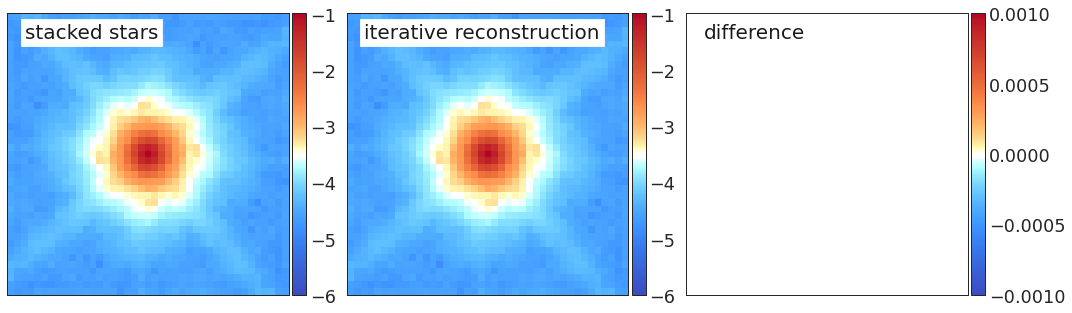

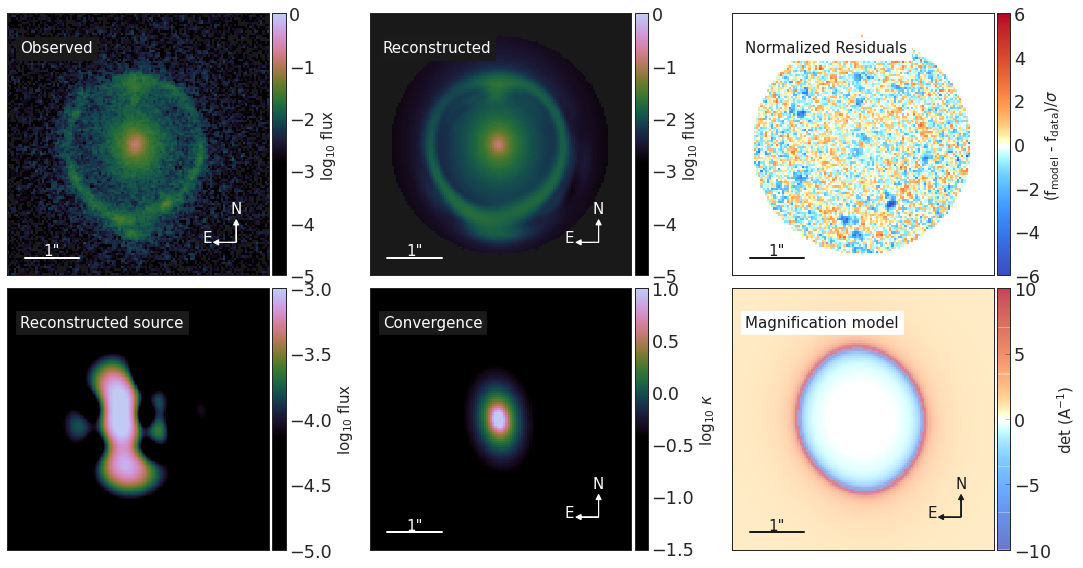

/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:496: RuntimeWarning: divide by zero encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,
/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/lenstronomy/Plots/model_band_plot.py:496: RuntimeWarning: invalid value encountered in log10
  im = ax.matshow(np.log10(model), origin='lower', vmin=v_min, vmax=v_max,


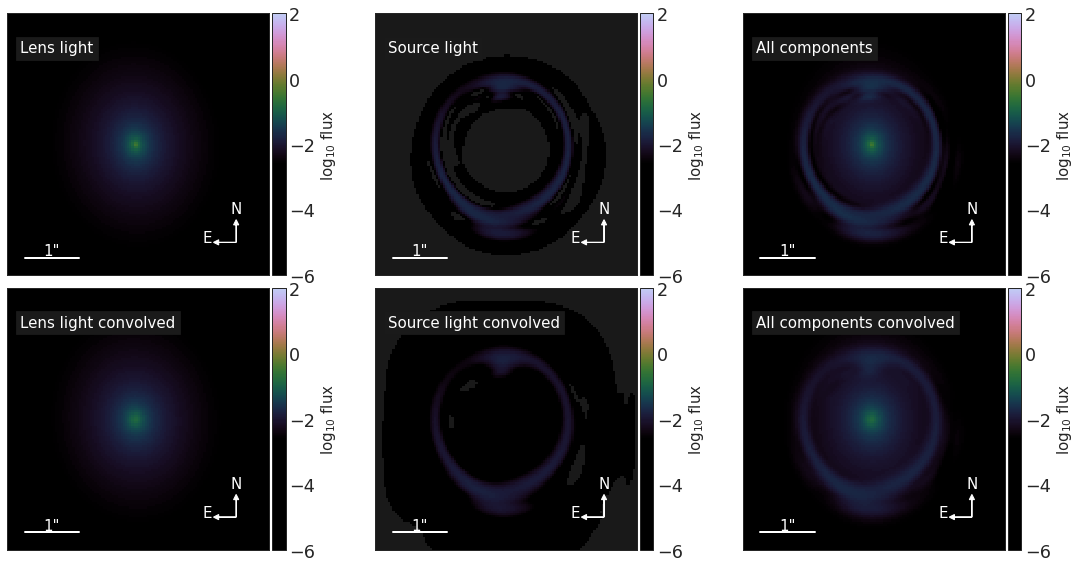

lens [{'theta_E': 1.2434336922799791, 'gamma': 2.6306495816238136, 'e1': -0.20677362229631768, 'e2': 0.0568694400960424, 'center_x': 0.05686660828230501, 'center_y': -0.026823567932265133}, {'gamma_ext': 0.017993951390016923, 'psi_ext': -1.407417505943753, 'ra_0': 0, 'dec_0': 0}] 

 source [{'amp': array([13.25416309, 12.34587286, -0.32372062,  4.5026219 ,  1.87823982,
        5.73875536, -2.75533839,  2.14599422,  5.14631545, -3.18109746,
       -4.50368436,  0.16754633,  1.96285461, -0.14566532,  4.27165845,
        1.23829033, -0.63351479, -0.66676888,  1.58298341,  3.02296491,
       -4.47768528,  3.9725635 , -1.20685161, -0.97285359,  1.65172327,
        1.29246584, -1.38745691,  2.94885136]), 'n_max': 6, 'beta': 0.14952081861889344, 'center_x': -0.04552914302530052, 'center_y': -0.27083415824308626}] 

 lens light [{'amp': 0.09808135970371258, 'R_sersic': 9.800615025324175, 'n_sersic': 6.672182311164191, 'e1': -0.0990363987169571, 'e2': 0.014139498742293, 'center_x': 0.0630353778

In [15]:
if analyse_output:
    
    band_i = 0
    
    kwargs_params = {
        'kwargs_lens': lens_result,
        'kwargs_source': source_result,
        'kwargs_lens_light': lens_light_result,
        'kwargs_ps': ps_result
    }
    

    kwargs_psf = multi_band_list_out[band_i][1]
    f, axes = chain_plot.psf_iteration_compare(kwargs_psf, vmin=-6, cmap=msh_cmap)
    f.show()
    
    lensPlot = ModelPlot(multi_band_list_out, kwargs_model, kwargs_params,
                        arrow_size=0.02, cmap_string=cmap,
                        likelihood_mask_list=mask, #kwargs_likelihood['image_likelihood_mask_list'],
                        multi_band_type='multi-linear'
                        )
    
    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)
    
    lensPlot.data_plot(ax=axes[0,0], band_index=band_i, v_min=-5, v_max=0) #, cmap='cubehelix') 
    lensPlot.model_plot(ax=axes[0,1], band_index=band_i, v_min=-5, v_max=0) 
    lensPlot.normalized_residual_plot(ax=axes[0,2], v_min=-6, v_max=6, band_index=band_i, cmap=msh_cmap)
    lensPlot.source_plot(ax=axes[1, 0], deltaPix_source=0.01, numPix=200, band_index=band_i, v_min=-5, v_max=-3) 
    lensPlot.convergence_plot(ax=axes[1, 1], v_max=1, band_index=band_i)
    lensPlot.magnification_plot(ax=axes[1, 2], cmap=msh_cmap, band_index=band_i)
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()

    f, axes = plt.subplots(2, 3, figsize=(16, 8), sharex=False, sharey=False)

    lensPlot.decomposition_plot(ax=axes[0,0], text='Lens light', lens_light_add=True, unconvolved=True, cmap=cmap, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,0], text='Lens light convolved', lens_light_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,1], text='Source light', source_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,1], text='Source light convolved', source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[0,2], text='All components', source_add=True, lens_light_add=True, unconvolved=True, band_index=band_i, v_min=-6, v_max=2) 
    lensPlot.decomposition_plot(ax=axes[1,2], text='All components convolved', source_add=True, lens_light_add=True, point_source_add=True, band_index=band_i, v_min=-6, v_max=2) 
    f.tight_layout()
    f.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0., hspace=0.05)
    plt.show()
    print('lens', lens_result, "\n\n source", source_result, '\n\n lens light', lens_light_result, '\n\n ps', ps_result)


1000 136 17


/home/s1/chinyi/.conda/envs/astroconda/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  import sys


theta_E_lens0 1.2494 ± 0.0111
gamma_lens0 2.6540 ± 0.0421
e1_lens0 -0.2179 ± 0.0160
e2_lens0 0.0649 ± 0.0144
center_x_lens0 0.0575 ± 0.0025
center_y_lens0 -0.0265 ± 0.0032
gamma_ext_lens1 0.0147 ± 0.0049
psi_ext_lens1 -1.2872 ± 1.5822
beta_source_light0 0.1510 ± 0.0044
center_x_source_light0 -0.0439 ± 0.0070
center_y_source_light0 -0.2788 ± 0.0102
R_sersic_lens_light0 9.6992 ± 0.4933
n_sersic_lens_light0 6.6389 ± 0.1118
e1_lens_light0 -0.0961 ± 0.0052
e2_lens_light0 0.0174 ± 0.0074
center_x_lens_light0 0.0629 ± 0.0015
center_y_lens_light0 -0.0292 ± 0.0013


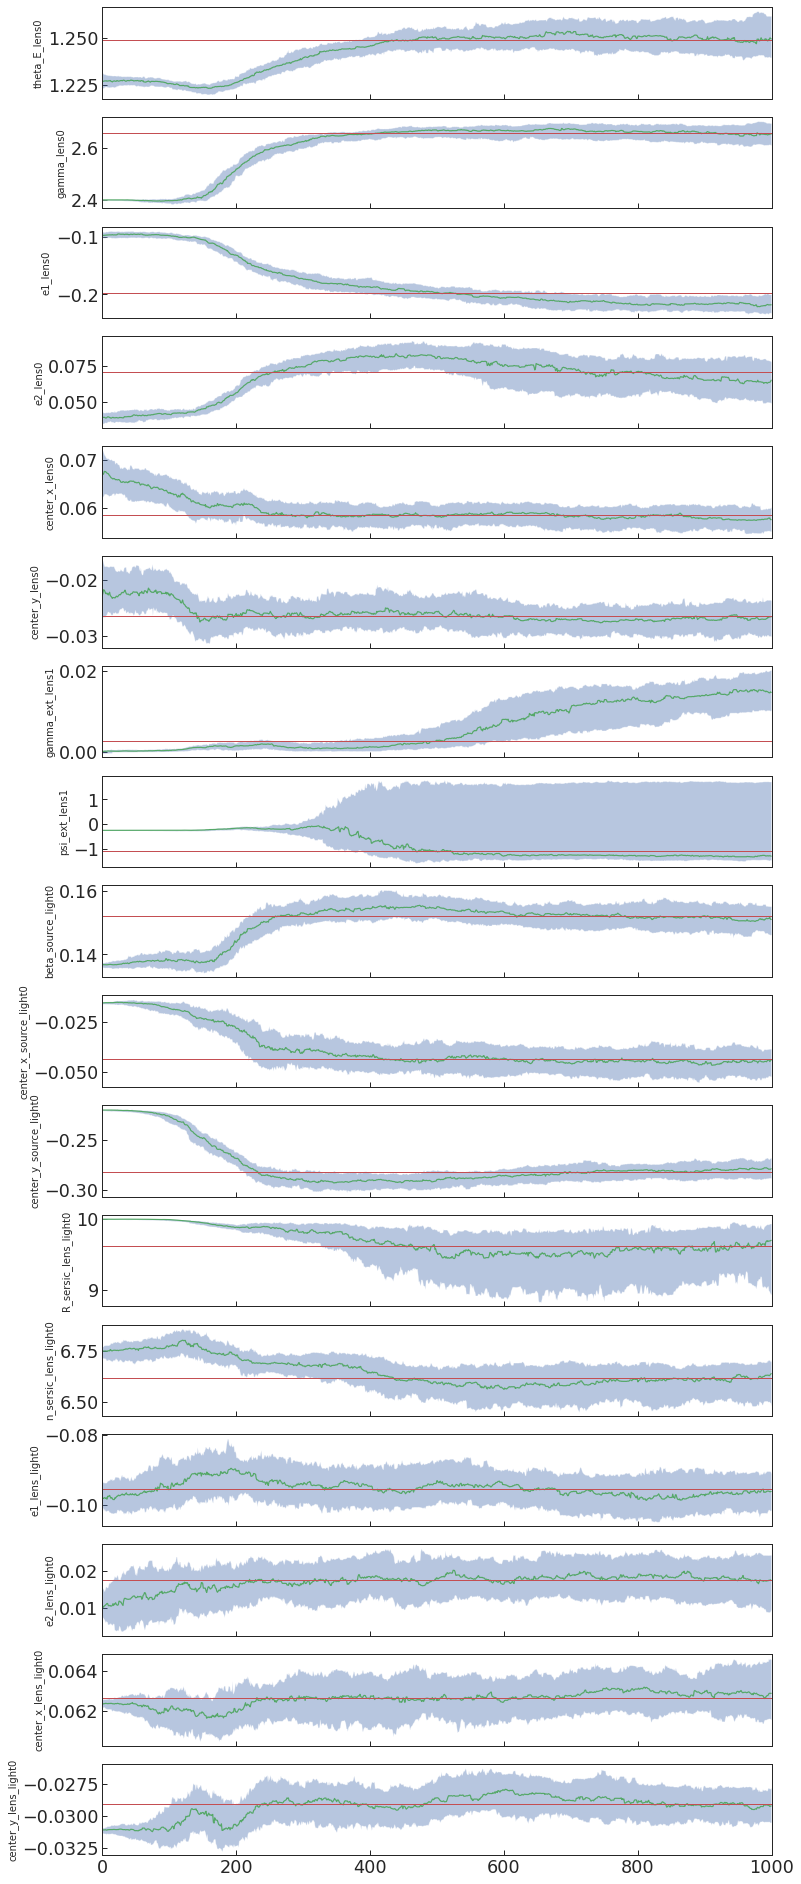

In [16]:
import time
samples_mcmc = []
if fit_output[-1][0] != 'PSO':
    samples_mcmc = fit_output[-1][1]
    param_mcmc = fit_output[-1][2]
    
if not samples_mcmc == []:
    #samples_mcmc = np.array(samples_mcmc)
    n_params = samples_mcmc.shape[1]
    n_walkers = 8 * n_params
    n_step = int(samples_mcmc.shape[0] / n_walkers)
    print(n_step, n_walkers, n_params)
    chain = np.empty((n_walkers, n_step, n_params))
    for i in np.arange(n_params):
        samples = samples_mcmc[:, i].T
        chain[:,:,i] = samples.reshape((n_step, n_walkers)).T
    #t = time.time()
    mean_pos = np.zeros((n_params, n_step))
    median_pos = np.zeros((n_params, n_step))
    std_pos = np.zeros((n_params, n_step))
    q16_pos = np.zeros((n_params, n_step))
    q84_pos = np.zeros((n_params, n_step))
    #chain = np.empty((nwalker, nstep, ndim), dtype = np.double)
    for i in np.arange(n_params):
        for j in np.arange(n_step):
            mean_pos[i][j] = np.mean(chain[:, j, i])
            median_pos[i][j] = np.median(chain[:, j, i])
            std_pos[i][j] = np.std(chain[:, j, i])
            q16_pos[i][j] = np.percentile(chain[:, j, i], 16.)
            q84_pos[i][j] = np.percentile(chain[:, j, i], 84.)
    #print('Elapsed time: %.2f s' % (time.perf_counter() - t))
    fig, ax = plt.subplots(n_params, sharex=True, figsize=(16, 2*n_params))
    burnin = -1000
    last = n_step
    medians = []
    param_values = [#lens_name, 
                   median_pos[0][last-1], (q84_pos[0][last-1]-q16_pos[0][last-1])/2,
                   median_pos[1][last-1], (q84_pos[1][last-1]-q16_pos[1][last-1])/2
                  ]
    #print(lens_values)
    for i in range(n_params):
        print(param_mcmc[i], '{:.4f} ± {:.4f}'.format(median_pos[i][last-1], (q84_pos[i][last-1]-q16_pos[i][last-1])/2))
        #ax[i].plot(mean_pos[i][:3000], c='b')
        ax[i].plot(median_pos[i][:last], c='g')
        #ax[i].axhline(np.mean(mean_pos[i][burnin:2900]), c='b')
        ax[i].axhline(np.median(median_pos[i][burnin:last]), c='r', lw=1)
        ax[i].fill_between(np.arange(last), q84_pos[i][:last], q16_pos[i][:last], alpha=0.4)
        #ax[i].fill_between(np.arange(last), mean_pos[i][:last]+std_pos[i][:last], mean_pos[i][:last]-std_pos[i][:last], alpha=0.4)
        ax[i].set_ylabel(param_mcmc[i], fontsize=10)
        ax[i].set_xlim(0, last)
        medians.append(np.median(median_pos[i][burnin:last]))
    if True:
        #plt.plot(mean_pos[11])
        #plt.plot(mean_pos[4])
        #plt.plot(mean_pos[2])
        #plt.plot(mean_pos[3])
        fig.set_size_inches((12., 2*len(param_mcmc)))
        #fig.tight_layout()
        plt.show()

In [17]:
random_params = np.random.choice(np.arange(len(samples_mcmc)-1), size=100)

random_samples = samples_mcmc[random_params]
random_samples.shape

(100, 17)

## 5th image

### read in data from fits files

## show image and determine shift and positions of point sources

## Corner plots